In [1]:
from utils.data import *
from utils.utils import *
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [55]:
province = 'istanbul'
source_type = 'terra'
dt_modis = retrieve_modis(province, source_type)

In [39]:
dt_ghs = rioxarray.open_rasterio(r'../../data/GHS_SMOD/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_20_4.tif', masked=True).squeeze()
dt_ghs = clip_subroutine(dt_ghs, 'istanbul', 'x', 'y')

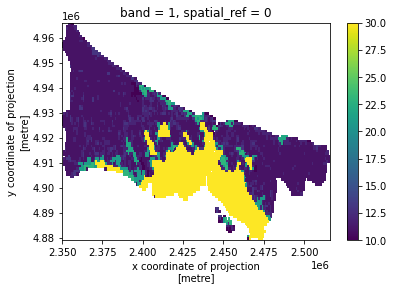

In [45]:
dt_ghs.plot()

In [46]:
urban_tiles = [21,22,23,30]
rural_tiles = [11,12,13]

In [49]:
# numbers starting with 2 or 3: urban
# numbers starting with 1 except 10: rural
# number 10: water

dt_ghs_class = xr.where(dt_ghs.isin(urban_tiles), 1, xr.where(dt_ghs.isin(rural_tiles), 0, np.nan))

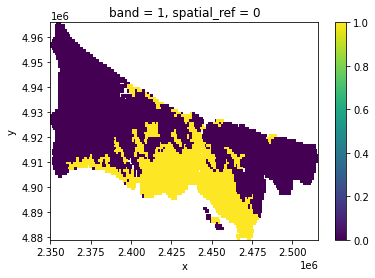

In [50]:
dt_ghs_class.plot()

In [53]:
def regrid_match(da_to_match, da_to_be_matched, da_to_match_crs, da_to_be_matched_crs):
    """
    Regrid a file grid to a target grid. Requires input data array
    
    Return target file and regridded file
    
    """
    
    # set crs for the target grid
    da_to_match = da_to_match.rio.write_crs(da_to_match_crs)
    da_to_match = da_to_match.rio.set_spatial_dims(x_dim='x', y_dim='y')
    
    # set crs for the file for which regridding will be performed
    da_to_be_matched = da_to_be_matched.rio.write_crs(da_to_be_matched_crs)
    da_to_be_matched = da_to_be_matched.rio.set_spatial_dims(x_dim='x', y_dim='y')
    
    
    da_to_be_matched = da_to_be_matched.rio.reproject_match(da_to_match).rename({'y':'y', 'x':'x', })
    
    
    return da_to_match, da_to_be_matched

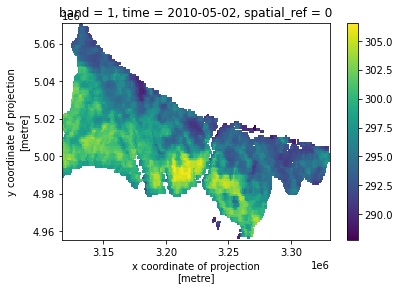

In [84]:
dt_modis[120].plot()

In [75]:
dt_ghs_repr, dt_modis_repr = regrid_match(dt_ghs_class, dt_modis,  dt_ghs.rio.crs, dt_modis.rio.crs,)

In [94]:
dt_modis_repr = xr.where(dt_modis_repr>500, np.nan, dt_modis_repr) # mask automatically created very big values

In [108]:
dt_modis_urban = xr.where(dt_ghs_repr==1, dt_modis_repr, np.nan)
dt_modis_rural = xr.where(dt_ghs_repr==0, dt_modis_repr, np.nan)

In [114]:
dt_modis_urban_flat = np.array(dt_modis_urban).flatten()
dt_modis_rural_flat = np.array(dt_modis_rural).flatten()

In [126]:
# remove nans
dt_modis_urban_flat = dt_modis_urban_flat[~np.isnan(dt_modis_urban_flat)]
dt_modis_rural_flat = dt_modis_rural_flat[~np.isnan(dt_modis_rural_flat)]

In [155]:
import scipy.stats 
from scipy.optimize import curve_fit

In [165]:
print(np.mean(dt_modis_urban_flat))
print(np.mean(dt_modis_rural_flat))

298.4171
295.5589


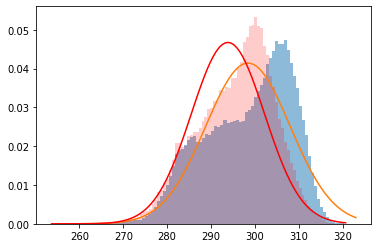

In [164]:
_, bins, _ = plt.hist(dt_modis_urban_flat, 100, density=1, alpha=0.5)
mu, sigma = scipy.stats.norm.fit(dt_modis_urban_flat)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

_, bins2, _ = plt.hist(dt_modis_rural_flat, 100, density=1, alpha=0.2, color='red')
mu, sigma = scipy.stats.norm.fit(dt_modis_rural_flat)
best_fit_line2 = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins2, best_fit_line2, color='red')

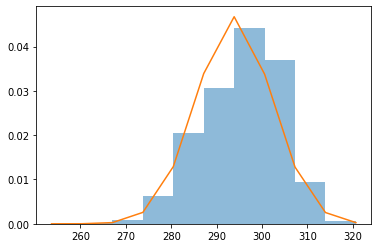

In [157]:
_, bins2, _ = plt.hist(dt_modis_rural_flat, 10, density=1, alpha=0.5)
mu, sigma = scipy.stats.norm.fit(dt_modis_rural_flat)
best_fit_line2 = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins2, best_fit_line2)

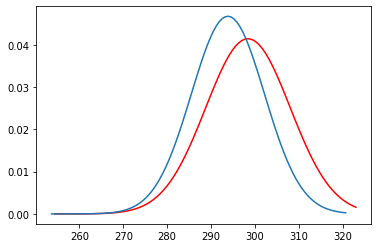

In [154]:
plt.plot(bins, best_fit_line, color='red')
plt.plot(bins2, best_fit_line2)